In [2]:
# https://youtu.be/tepxdcepTbY
"""
@author: Sreenivas Bhattiprolu

Code tested on Tensorflow: 2.2.0
    Keras: 2.4.3

dataset: https://finance.yahoo.com/quote/GE/history/
Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
"""

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

In [3]:
#Read the csv file
df = pd.read_csv('../datas/GE.csv')
print(df.head()) #7 columns, including the Date. 

         Date      Open      High       Low     Close  Adj Close  Volume
0  1962-01-02  6.009615  6.109776  5.949519  5.989583   1.008423  269568
1  1962-01-03  5.959535  5.959535  5.909455  5.929487   0.998305  184704
2  1962-01-04  5.929487  5.979567  5.809295  5.859375   0.986501  229632
3  1962-01-05  5.859375  5.869391  5.608974  5.709135   0.961206  340704
4  1962-01-08  5.709135  5.709135  5.528846  5.699119   0.959520  386880


In [4]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

15277   2022-09-09
15278   2022-09-12
15279   2022-09-13
15280   2022-09-14
15281   2022-09-15
15282   2022-09-16
15283   2022-09-19
15284   2022-09-20
15285   2022-09-21
15286   2022-09-22
15287   2022-09-23
15288   2022-09-26
15289   2022-09-27
15290   2022-09-28
15291   2022-09-29
Name: Date, dtype: datetime64[ns]


In [5]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


<AxesSubplot:>

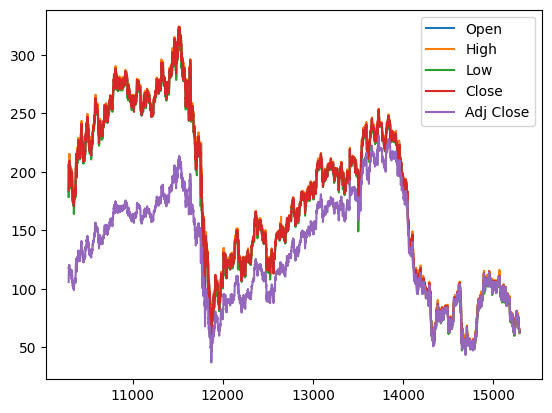

In [6]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()


In [7]:
df_for_training

,Open,High,Low,Close,Adj Close
0,6.009615,6.109776,5.949519,5.989583,1.008423
1,5.959535,5.959535,5.909455,5.929487,0.998305
2,5.929487,5.979567,5.809295,5.859375,0.986501
3,5.859375,5.869391,5.608974,5.709135,0.961206
4,5.709135,5.709135,5.528846,5.699119,0.959520
...,...,...,...,...,...
15287,64.550003,65.080002,63.549999,64.550003,64.470001
15288,64.529999,66.160004,64.209999,64.349998,64.349998
15289,64.849998,65.309998,63.509998,64.470001,64.470001
15290,64.989998,65.059998,64.190002,64.459999,64.459999


In [8]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [9]:
df_for_training_scaled

array([[-0.86944485, -0.86881452, -0.86954486, -0.86944118, -0.88309489],
       [-0.86992282, -0.87023293, -0.86993166, -0.87001472, -0.88323686],
       [-0.8702096 , -0.87004381, -0.87089868, -0.87068384, -0.88340248],
       ...,
       [-0.30786316, -0.30991253, -0.31381525, -0.31132346,  0.00734213],
       [-0.30652697, -0.31227275, -0.30725001, -0.31141892,  0.00720179],
       [-0.31817082, -0.32124156, -0.32916623, -0.32792946, -0.01707204]])

In [7]:
np.shape(df_for_training_scaled)

(15292, 5)

In [8]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [9]:
len(df_for_training_scaled)

15292

In [10]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (15278, 14, 5).
trainY shape == (15278, 1).


In [11]:
#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [12]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
860/860 [==============================] - 18s 17ms/step - loss: 0.0468 - val_loss: 0.0038
Epoch 2/5
860/860 [==============================] - 14s 16ms/step - loss: 0.0275 - val_loss: 0.0030
Epoch 3/5
860/860 [==============================] - 8s 9ms/step - loss: 0.0247 - val_loss: 0.0023
Epoch 4/5
860/860 [==============================] - 7s 8ms/step - loss: 0.0260 - val_loss: 0.0058
Epoch 5/5
860/860 [==============================] - 8s 9ms/step - loss: 0.0254 - val_loss: 0.0062


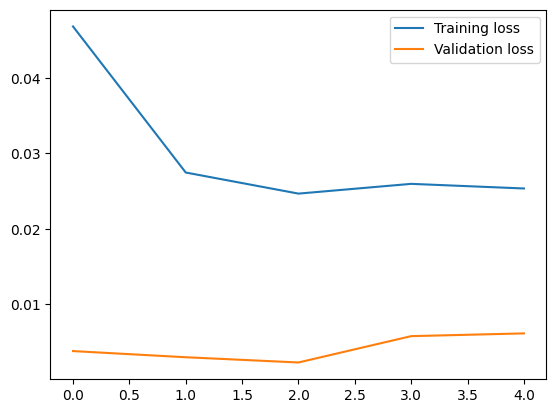

In [13]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [44]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=200 #let us predict past 15 days

In [45]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2022-09-08 00:00:00', freq='C'), Timestamp('2022-09-09 00:00:00', freq='C'), Timestamp('2022-09-12 00:00:00', freq='C'), Timestamp('2022-09-13 00:00:00', freq='C'), Timestamp('2022-09-14 00:00:00', freq='C'), Timestamp('2022-09-15 00:00:00', freq='C'), Timestamp('2022-09-16 00:00:00', freq='C'), Timestamp('2022-09-19 00:00:00', freq='C'), Timestamp('2022-09-20 00:00:00', freq='C'), Timestamp('2022-09-21 00:00:00', freq='C'), Timestamp('2022-09-22 00:00:00', freq='C'), Timestamp('2022-09-23 00:00:00', freq='C'), Timestamp('2022-09-26 00:00:00', freq='C'), Timestamp('2022-09-27 00:00:00', freq='C'), Timestamp('2022-09-28 00:00:00', freq='C'), Timestamp('2022-09-29 00:00:00', freq='C'), Timestamp('2022-09-30 00:00:00', freq='C'), Timestamp('2022-10-03 00:00:00', freq='C'), Timestamp('2022-10-04 00:00:00', freq='C'), Timestamp('2022-10-05 00:00:00', freq='C'), Timestamp('2022-10-06 00:00:00', freq='C'), Timestamp('2022-10-07 00:00:00', freq='C'), Timestamp('2022-10-11 00:00:00'

In [46]:
trainX[-2:].shape

(2, 14, 5)

In [47]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

7/7 [==============================] - 0s 3ms/step


In [48]:
prediction

array([[-0.00790916],
       [-0.01219916],
       [-0.01836016],
       [-0.02367549],
       [-0.02903635],
       [-0.03493758],
       [-0.03891703],
       [-0.04072414],
       [-0.04056863],
       [-0.03905305],
       [-0.03608739],
       [-0.03288251],
       [-0.0299136 ],
       [-0.02789607],
       [-0.02512087],
       [-0.01924927],
       [-0.01178828],
       [-0.0042258 ],
       [ 0.00321863],
       [ 0.00926077],
       [ 0.01470955],
       [ 0.01987761],
       [ 0.02482311],
       [ 0.02888693],
       [ 0.03250685],
       [ 0.03425589],
       [ 0.0328137 ],
       [ 0.02768926],
       [ 0.01972815],
       [ 0.00747288],
       [-0.00553625],
       [-0.01758574],
       [-0.02766987],
       [-0.03374048],
       [-0.03363002],
       [-0.02941283],
       [-0.02346717],
       [-0.01661532],
       [-0.00927006],
       [-0.00257685],
       [ 0.00318164],
       [ 0.00721028],
       [ 0.00887841],
       [ 0.00784235],
       [ 0.00871146],
       [ 0

In [49]:


#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [50]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

C:\Users\i5_4thGen\AppData\Local\Temp\ipykernel_15680\3987748712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


<AxesSubplot:xlabel='Date', ylabel='Open'>

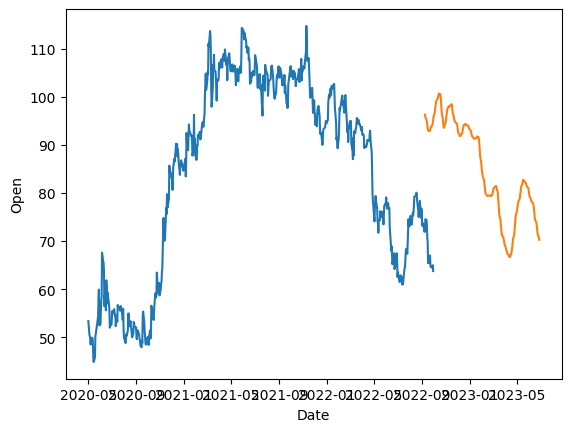

In [51]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(x=original['Date'], y=original['Open'])
sns.lineplot(x=df_forecast['Date'], y=df_forecast['Open'])